#### Labels transfer from gut healthy adult single-cell RNA sequencing cells to Xenium data
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 30th January 2024

##### Import packages

In [ ]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Setup cells

In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 1.0.4


In [3]:
%matplotlib inline
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.set_float32_matmul_precision('medium')

In [6]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2023.07.22
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [7]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

##### Data Upload

In [8]:
input = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Healthy_reference/Integrated/Healthy_integrated_data_all_genes.h5ad'
adata_ref = sc.read_h5ad(input)

In [9]:
X_is_raw(adata_ref)

True

In [10]:
# upload h5 object
adata_xenium = sc.read_10x_h5('/mnt/LaCIE/annaM/gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_pallet/outs/cell_feature_matrix.h5')

reading /mnt/LaCIE/annaM/gut_project/raw_data/Xenium_10X_datasets/Gut_samples/Non-diseased_pre-designed_pallet/outs/cell_feature_matrix.h5
 (0:00:00)


In [11]:
X_is_raw(adata_xenium)

True

+ Save raw counts

In [12]:
adata_ref.raw = adata_ref

In [13]:
adata_xenium.raw = adata_xenium

+ Prepare obs

In [14]:
adata_ref = adata_ref[adata_ref.obs['Age_group'] == 'Adult']

In [15]:

adata_ref.obs['seed_labels'] = adata_ref.obs['Cell Type'].copy()

/tmp/ipykernel_1534012/3670880317.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ref.obs['seed_labels'] = adata_ref.obs['Cell Type'].copy()


In [16]:
adata_xenium.obs['seed_labels'] = 'Unknown'

In [17]:
adata_xenium.obs['Donor_ID'] = 'Xenium_donor_1'

In [18]:
adata_xenium.obs['Library_Preparation_Protocol'] = 'Xenium'

In [19]:
adata_xenium.obs['Study_name'] = '10X_Xenium_gut_data'

+ Concatenate datasets

In [31]:
adata = adata_ref.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)

/tmp/ipykernel_1534012/3396050185.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_ref.concatenate(adata_xenium, batch_key = 'dataset', batch_categories = ['reference', 'query'], join='inner', index_unique = None)


+ Run scVI

In [32]:
adata.layers['counts'] = adata.X.copy()

In [33]:
scvi.model.SCVI.setup_anndata(adata, categorical_covariate_keys=['Donor_ID', 'Library_Preparation_Protocol', 'Study_name'],
                              labels_key = "seed_labels", layer = 'counts')

In [34]:
scvi_model = scvi.model.SCVI(adata, n_latent = 50, n_layers = 3, dispersion = 'gene-batch', gene_likelihood = 'nb')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/model/_scvi.py:127: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [35]:
scvi_model.train(400)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|██████████████████████████████████████████████| 400/400 [2:29:45<00:00, 23.41s/it, v_num=1, train_loss_step=87.1, train_loss_epoch=85.3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████| 400/400 [2:29:45<00:00, 22.46s/it, v_num=1, train_loss_step=87.1, train_loss_epoch=85.3]


<Axes: xlabel='epoch'>

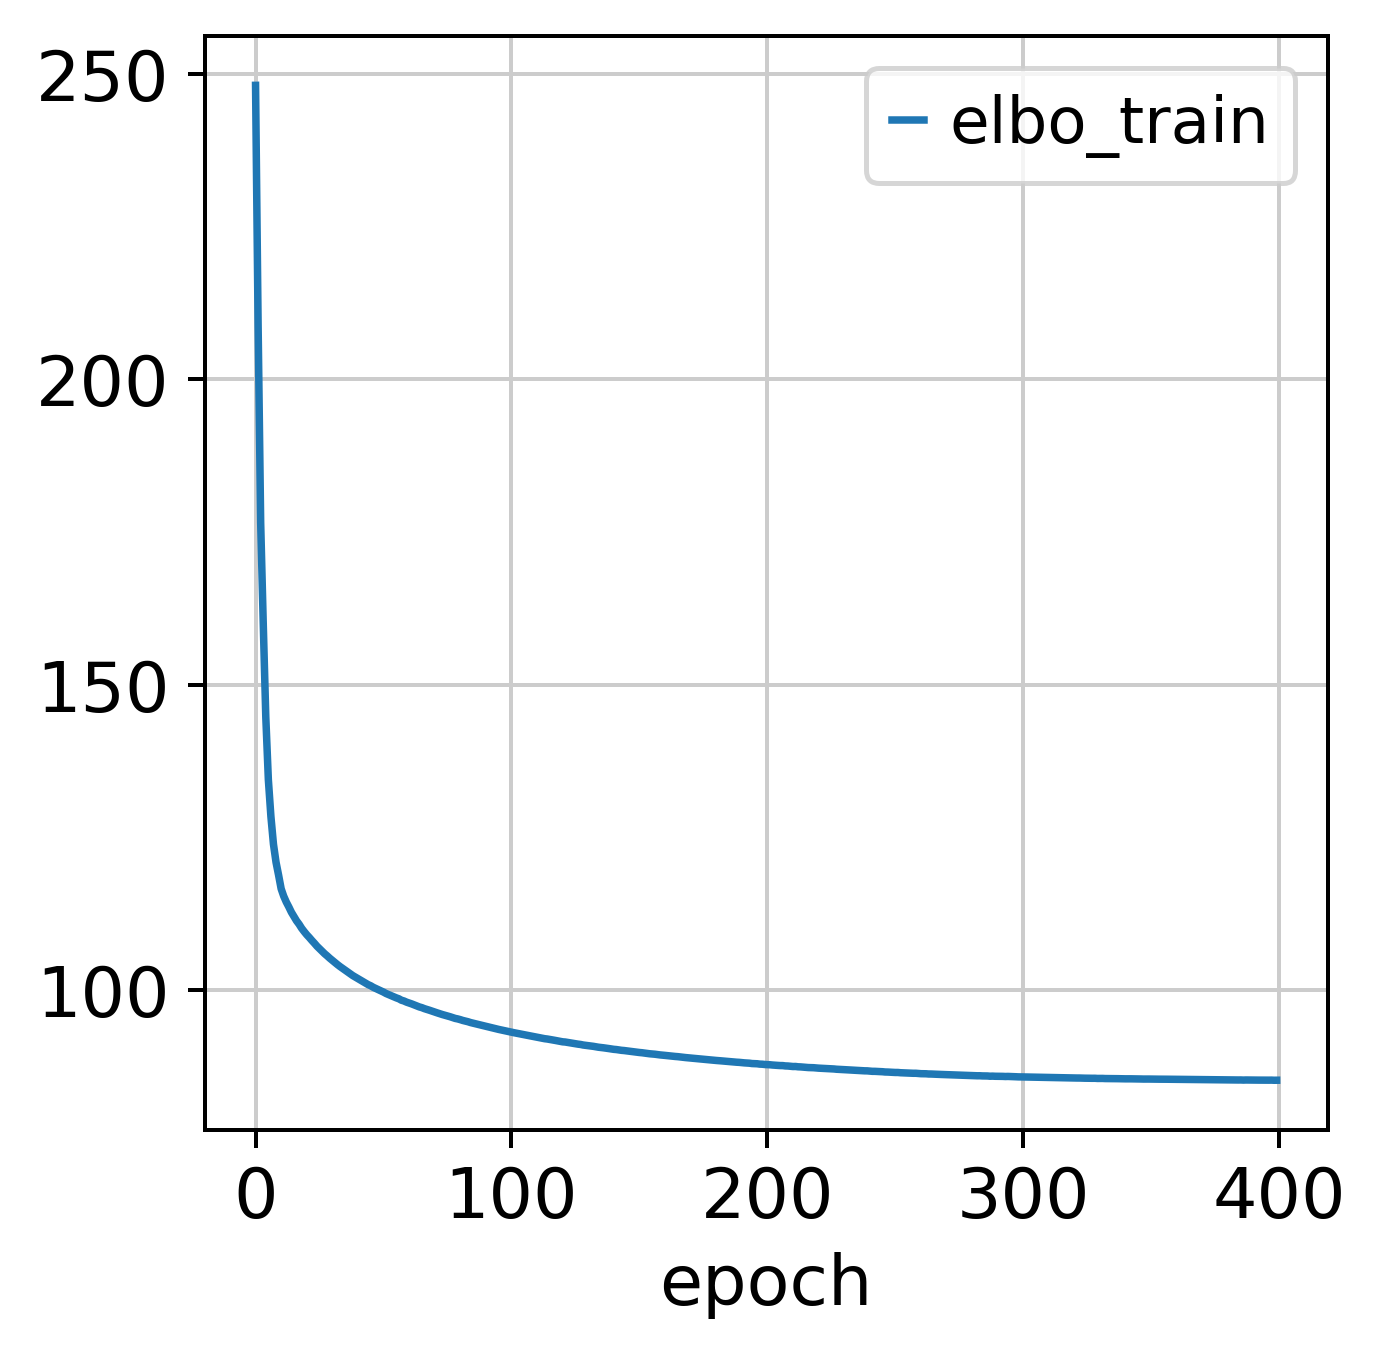

In [44]:
# plot training history
scvi_model.history['elbo_train'].plot()

In [37]:
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()

In [42]:
scvi_model.history

{'kl_weight':       kl_weight
 epoch          
 0           0.0
 1        0.0025
 2         0.005
 3        0.0075
 4          0.01
 ...         ...
 395      0.9875
 396        0.99
 397      0.9925
 398       0.995
 399      0.9975
 
 [400 rows x 1 columns],
 'train_loss_step':       train_loss_step
 epoch                
 0           80.017128
 1           70.609283
 2           73.087158
 3           72.675674
 4           75.054497
 ...               ...
 395         87.922729
 396         87.127632
 397          88.75528
 398         87.529648
 399         87.110703
 
 [400 rows x 1 columns],
 'train_loss_epoch':       train_loss_epoch
 epoch                 
 0              81.5056
 1            75.780441
 2            74.891251
 3            74.490028
 4            74.192284
 ...                ...
 395          85.204231
 396          85.224915
 397          85.245987
 398          85.239426
 399          85.258896
 
 [400 rows x 1 columns],
 'elbo_train':        elbo_train
 e

+ Transfer of annotations with scANVI

In [38]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scvi/model/_scanvi.py:140: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [39]:
scanvi_model.train(50)

INFO     Training for 50 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 50/50 [46:00<00:00, 50.81s/it, v_num=1, train_loss_step=125, train_loss_epoch=127]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|██████████████████████████████████████████████████████| 50/50 [46:00<00:00, 55.21s/it, v_num=1, train_loss_step=125, train_loss_epoch=127]


In [51]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

In [40]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [52]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/10X_Xenium_data/scRNA_and_Xenium_data_scANVI.h5ad')

+ Visualize dataset

In [48]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:53)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:05:34)


/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/amaguza/miniforge3/envs/scvi_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categoric

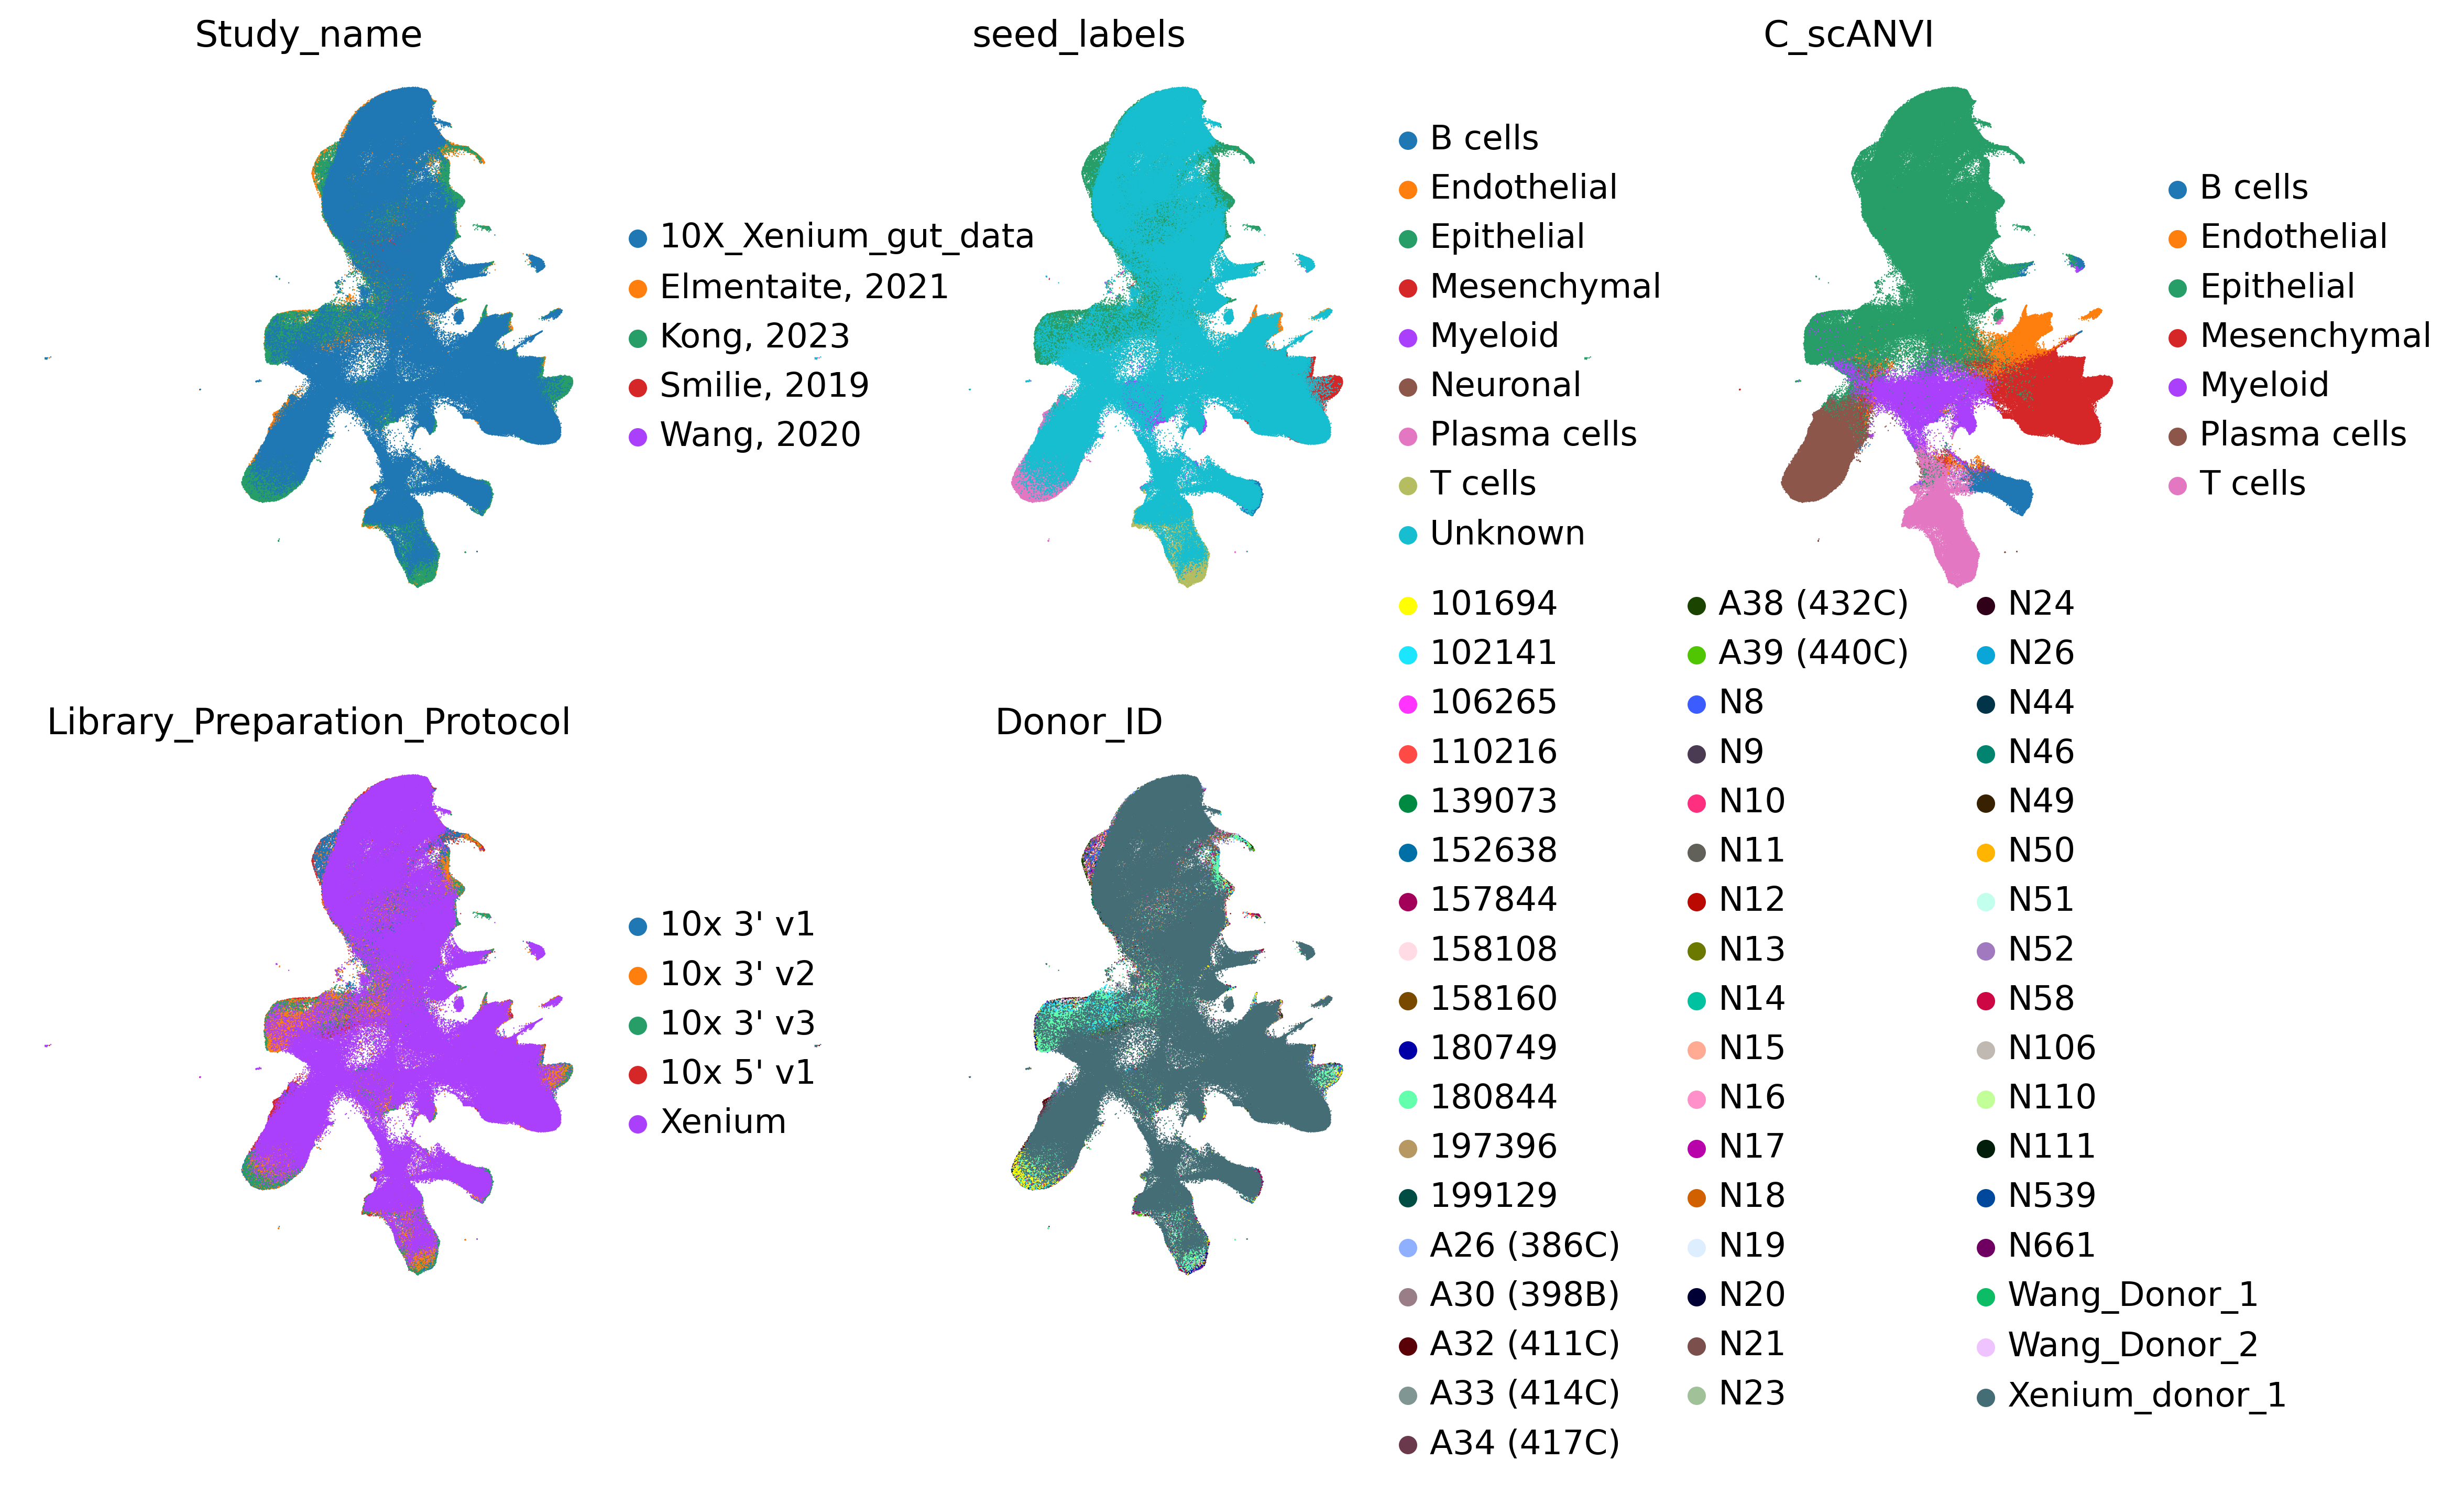

In [55]:
sc.pl.umap(adata, color = ['Study_name', 'seed_labels', 'C_scANVI', 'Library_Preparation_Protocol', 'Donor_ID'], ncols = 3, frameon = False, size = 1)

+ Models Validation

/tmp/ipykernel_1534012/3652480649.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = adata.obs.groupby(['Cell Type', "C_scANVI"]).size().unstack(fill_value=0)


Text(0, 0.5, 'Observed')

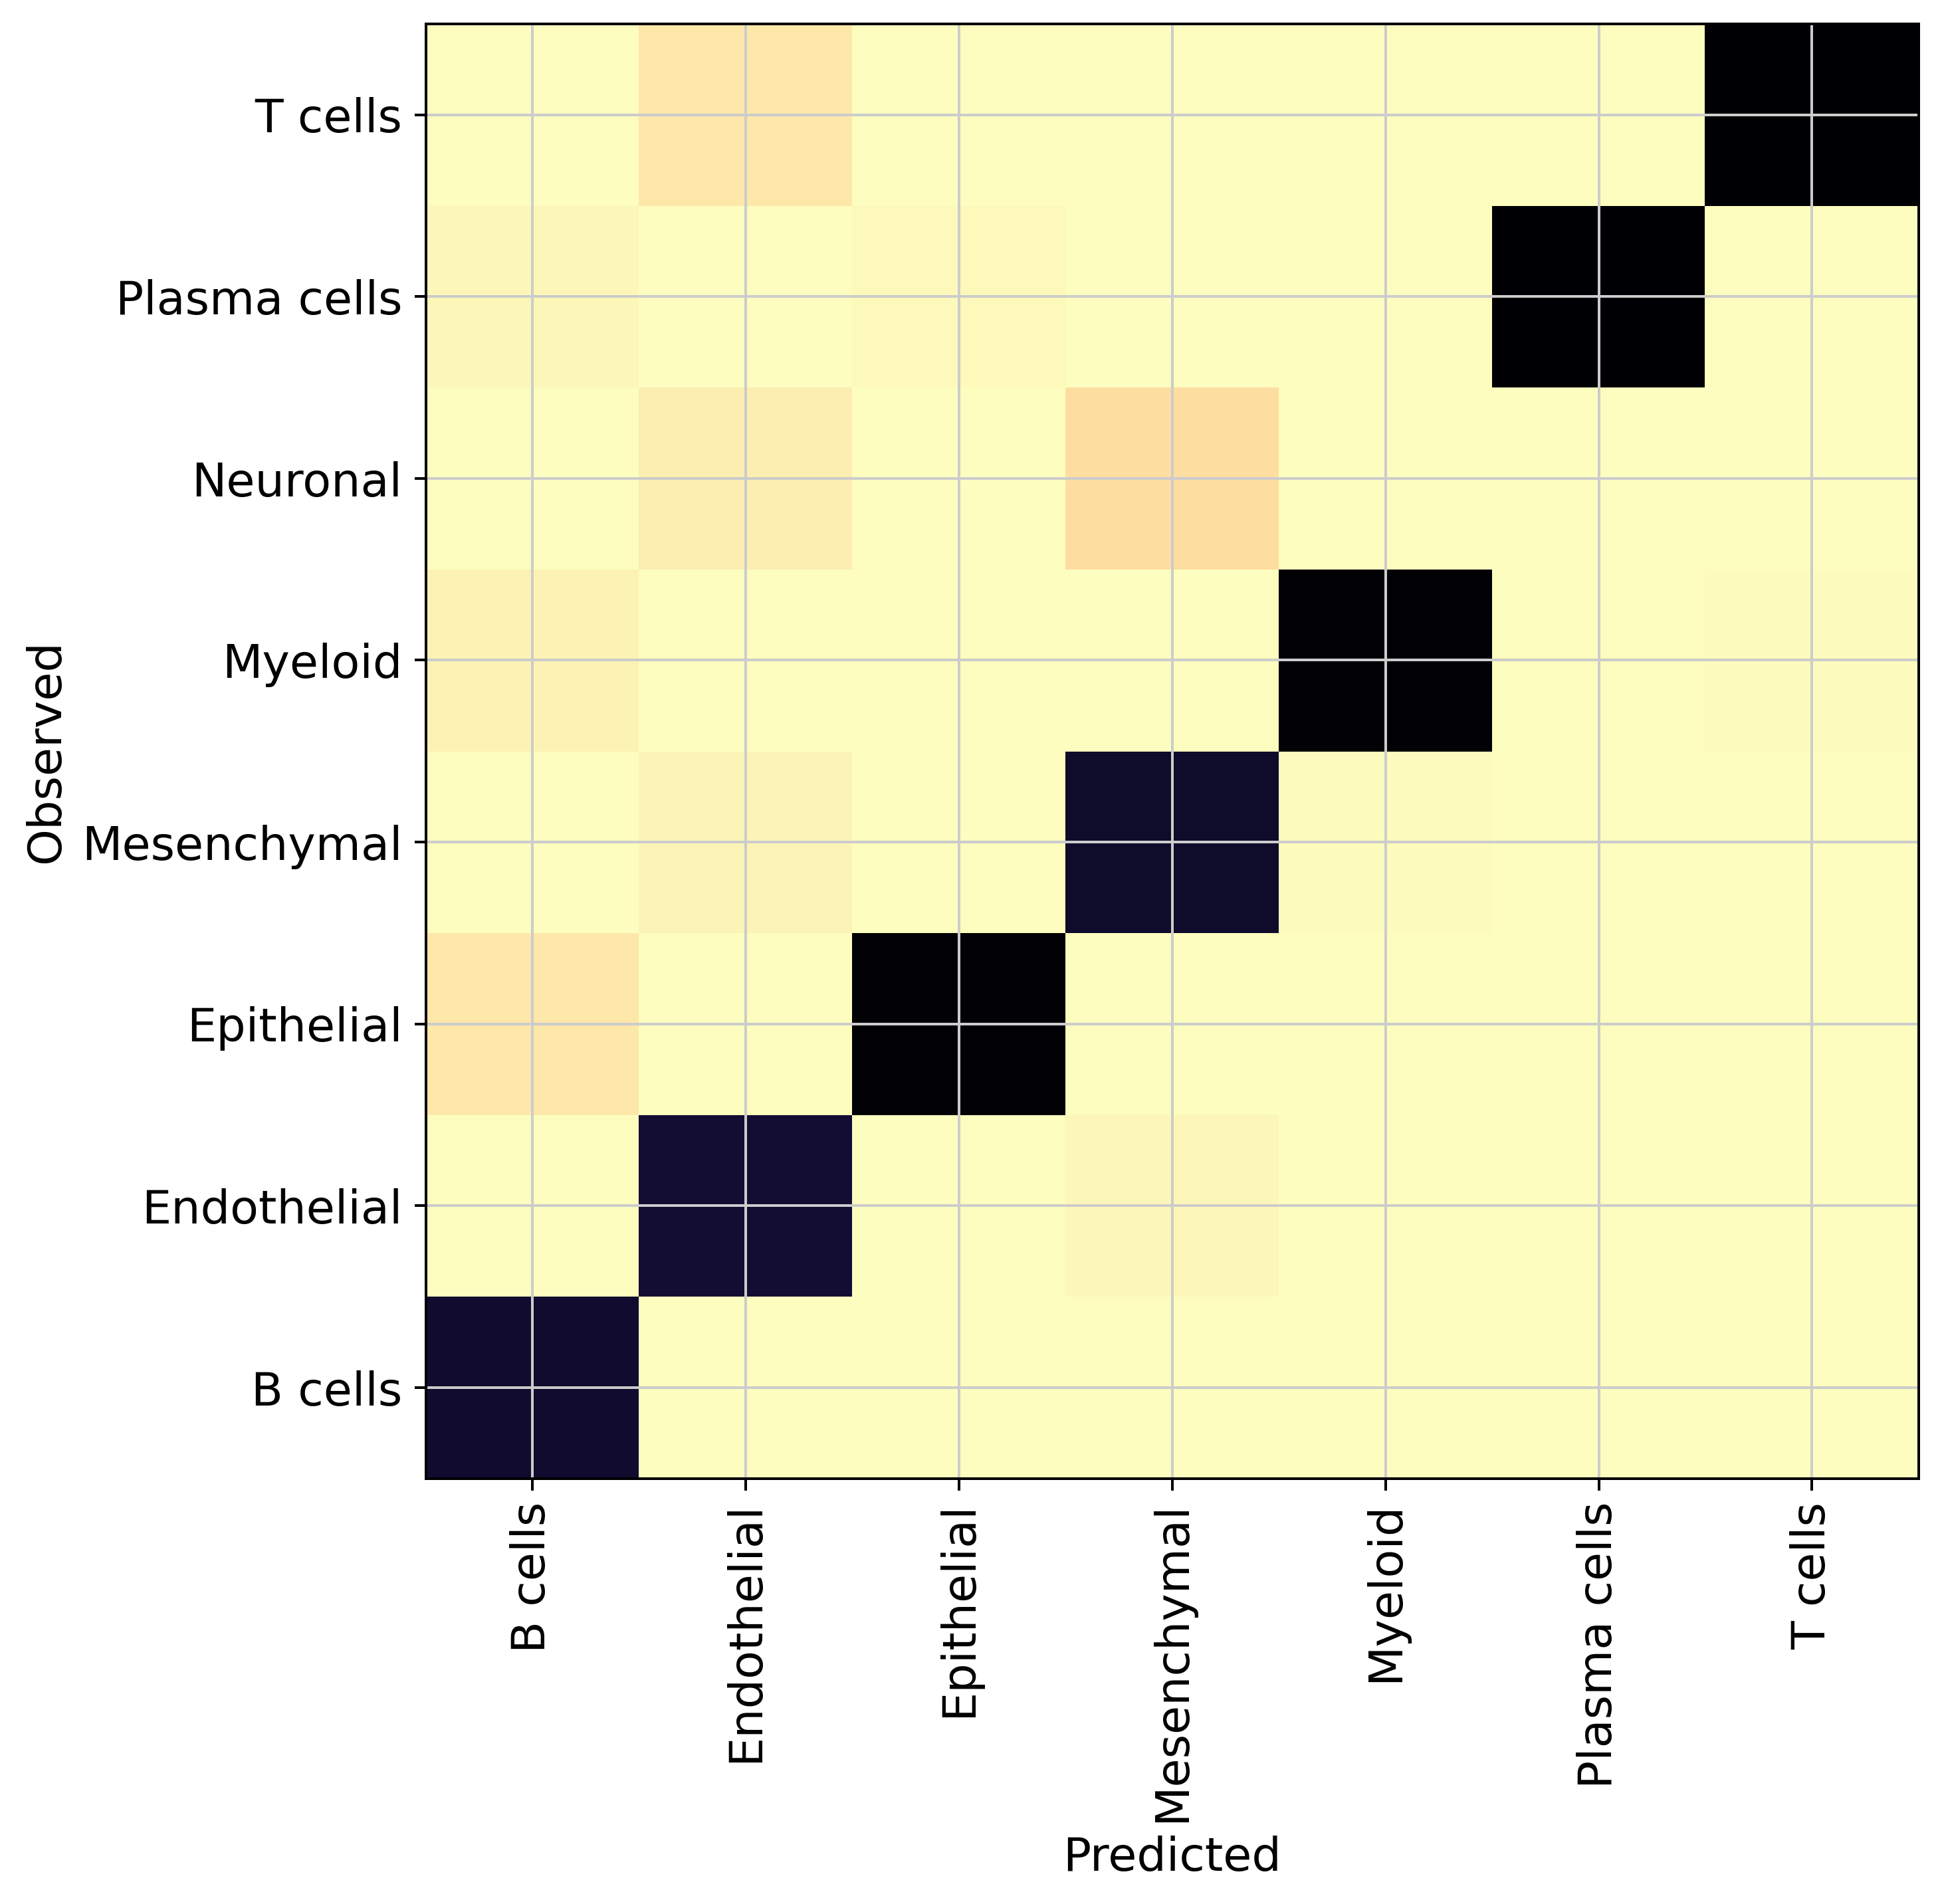

In [56]:
#Validation of the clusters
df = adata.obs.groupby(['Cell Type', "C_scANVI"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")